In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import sigmoid
import logging

2025-03-03 19:47:34.139675: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-03 19:47:34.170243: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-03 19:47:34.607477: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
dlc = dict(dlblue = '#0096ff', dlorange = '#FF9300', dldarkred='#C00000', dlmagenta='#FF40FF', dlpurple='#7030A0', dldarkblue =  '#0D5BDC')

In [3]:
def coffee_data():
    """
        Creates a data coffee roasting data set.
        rosting duration [X]
        temperature range[Y]
    """

    rng = np.random.default_rng(2) #default_rng-> Construct a new Generator with the default BitGenerator(PCG64)
                                     #Advantages:
                                    # · Better random number generation algorithms
                                    # · Explicit control over the random state
                                    # · Improved modularity and separation of concerns
                                    # · Enhanced functionality and reproductibility
                                    # · Avoidance of global state issues
                                    # PCG64 is a modern and high-quality random number generator. It offers better statistical properties
                                    # and performance compared to the older Mersenne Twister algorithm used by numpy.random. (rand or randint)
    X = rng.random(400).reshape(-1,2) #reshape changes the dimensions (shape) of an array while keeping the underlying data unchanged. Do not create a copy!
                                        # -1 is used for one dimension, NumPy will automatically calculate the correct size for that dimension
                                        # In this case (-1, 2), it will be changed to 2 columns, automatically will calculate the rows

    X[:,1] = X[:,1] * 4 + 11.5               #12-15 min is best
    X[:,0] = X[:,0] * (285-150) + 150       #350-500 F (175-260) is best

    Y = np.zeros(len(X))

    i = 0
    for t,d in X:
        y = -3/(260-175)*t + 21
        if (t > 175 and t < 260 and d > 12 and d < 15 and d <= y):
            Y[i] = 1
        else:
            Y[i] = 0
        i += 1
    return (X, Y.reshape(-1,1))

# Loading the data

In [4]:
X,Y = coffee_data();
print(X.shape, Y.shape)

(200, 2) (200, 1)


X is a 200x2 matrix (first column: duration, second column: temperature)\
Y is 200x1 column-matrix (target values)

# Plotting the data

In [5]:
def plt_roast(X, Y):
    Y = Y.reshape(-1,)
    colormap = np.array(['r', 'b'])
    fig, ax = plt.subplots(1,1,)
    ax.scatter(X[Y==1,0], X[Y==1,1], s=70, marker='x', c='red', label='Good')
    ax.scatter(X[Y==0,0], X[Y==0,1], s=100, marker='o', facecolors='none', edgecolors=dlc["dldarkblue"], linewidth=1, label='Bad')
    tr = np.linspace(175,260,50)
    ax.plot(tr, (-3/85) * tr + 21, color=dlc["dlpurple"], linewidth=1)
    ax.axhline(y=12, color=dlc["dlpurple"], linewidth=1)
    ax.axvline(x=175, color=dlc["dlpurple"], linewidth=1)
    ax.set_title(f"Coffee Roasting", size=16)
    ax.set_xlabel("Temperature \n(Celsius)", size=12)
    ax.set_ylabel("Duration \n(minutes)", size=12)
    ax.legend(loc='upper right')
    plt.show()

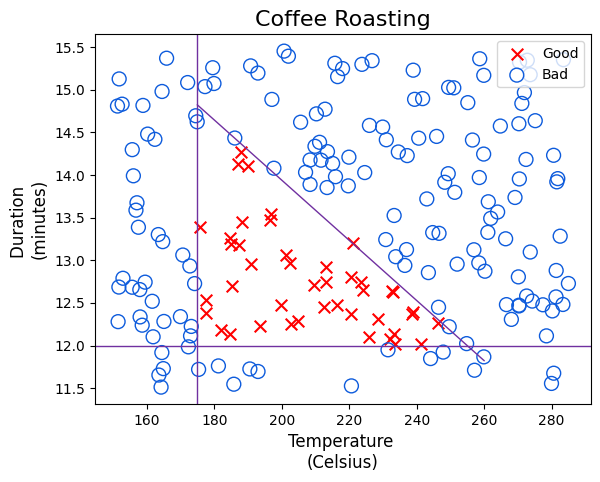

In [6]:
plt_roast(X, Y)

# Normalizing the data

<h5>Fitting the weights to the data will proceed more quickly if the data is normalized<h5>

In [7]:
print(f"Temperature Max, Min pre normalization: {np.max(X[:,0]):0.2f}, {np.min(X[:,0]):0.2f}")
print(f"Duration Max, Min pre normalization: {np.max(X[:,1]):0.2f}, {np.min(X[:,1]):0.2f}")
norm_l = tf.keras.layers.Normalization(axis=-1)
norm_l.adapt(X) #learns means, variance
Xn = norm_l(X)
print(f"Temperature Max, Min pre normalization: {np.max(Xn[:,0]):0.2f}, {np.min(Xn[:,0]):0.2f}")
print(f"Duration Max, Min pre normalization: {np.max(Xn[:,1]):0.2f}, {np.min(Xn[:,1]):0.2f}")


Temperature Max, Min pre normalization: 284.99, 151.32
Duration Max, Min pre normalization: 15.45, 11.51
Temperature Max, Min pre normalization: 1.66, -1.69
Duration Max, Min pre normalization: 1.79, -1.70


2025-03-03 19:47:35.253940: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-03 19:47:35.254194: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


# Copying the data

<h5>Copying our data to increase the training set size and reduce the number of training epoches<h5>


In [8]:
Xt = np.tile(Xn,(1000,1))
Yt = np.tile(Y,(1000,1))
print(Xt.shape, Yt.shape)

(200000, 2) (200000, 1)


# **TensorFlow Model**

### Model

In [9]:
tf.random.set_seed(1234) #applied to achieve consistent results
model = Sequential(
    [
        tf.keras.Input(shape=(2,)),
        Dense(3, activation='sigmoid', name='layer1'),
        Dense(1, activation='sigmoid', name='layer2')
    ]
)

The tf.keras.Input(shape=(2,)) specifies the expected shape of the input. This allows TensorFlow to size the weights and bias parameters at this point. This statement can be ommited in practice and TensorFlow will size the networkparameters when the input data is specified in the *model.fit* statement.

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ layer1 (Dense)                  │ (None, 3)              │             9 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer2 (Dense)                  │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13 (52.00 B)

 Trainable params: 13 (52.00 B)

 Non-trainable params: 0 (0.00 B)

The ***model.summary()*** provides a description of the network

The parameters counts shown in the summary correspond to the number of elements in the weight and bias arrays as shown below:

In [11]:
L1_num_params = 2 * 3 + 3 #W1 parameters + b1 parameters
L2_num_params = 3 * 1 + 1 #W2 parameters + b2 parameters
print("L1 params = ", L1_num_params, ", L2 params = ", L2_num_params)

L1 params =  9 , L2 params =  4


Let's examine the weights and biases TensorFlow has instantiated. The weights *W* should be of size (number of features in input, number of units in the layer) while the bias *b* size should match the number of units in the layer.

In [12]:
W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()
print(f"W1{W1.shape}:\n", W1,f"W2{b1.shape}:", b1)
print(f"W1{W2.shape}:\n", W2,f"W2{b2.shape}:", b2)

W1(2, 3):
 [[-1.0307596   0.93915296 -0.7392484 ]
 [ 1.0284522  -0.82104456  0.2703966 ]] W2(3,): [0. 0. 0.]
W1(3, 1):
 [[ 0.06764519]
 [-0.0476979 ]
 [-0.3739456 ]] W2(1,): [0.]


### **To takee into account:**
- The *model.compile* statement defines a loss function and specifies a compile optimization.  
- The *model.fit* statement runs gradient descent and fits the weights to the data.

In [13]:
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
)

model.fit(
    Xt, Yt,
    epochs=10,
)

Epoch 1/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 2s 312us/step - loss: 0.3312
Epoch 2/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 2s 285us/step - loss: 0.1260
Epoch 3/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 2s 311us/step - loss: 0.1159
Epoch 4/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 2s 295us/step - loss: 0.1055
Epoch 5/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 2s 312us/step - loss: 0.0232
Epoch 6/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 2s 314us/step - loss: 0.0130
Epoch 7/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 2s 275us/step - loss: 0.0088
Epoch 8/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 2s 274us/step - loss: 0.0062
Epoch 9/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 2s 272us/step - loss: 0.0045
Epoch 10/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 2s 324us/step - loss: 0.0032


`tf.keras.losses.BinaryCrossentropy` computes the cross-entropy loss between true labels and predicted labels.  
  
Use this cross-entropy loss for binary(0 or 1) classification applications.

`tf.keras.optimizers.Adam`implements the Adam algorithm. Adam algorithm is a stochastic gradient descent method that is baed on adaptive estimation of first-order and second-order moments. See *Kingma et al., 2014*. This algorithm is well suited for problems that are large in terms of data/parameters.


Now, the weights have been updated:

In [14]:
W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()
print("W1:\n", W1, "\nb1:", b1)
print("W2:\n", W2, "\nb2:", b2)

W1:
 [[ 14.456852    -0.04198976 -10.426656  ]
 [ 12.071448    -9.020431    -0.18509749]] 
b1: [  1.7905128 -11.2912    -11.390399 ]
W2:
 [[-38.546574]
 [-40.804607]
 [-44.3716  ]] 
b2: [23.303057]


In [15]:
#Set weights from a previous run. To run with the values of my model, just omit this code
W1 = np.array([
    [-9.94, 0.29, 12.89],
    [-0.17, -7.34, 10.79]] )
b1 = np.array([-9.87, -9.28, 1.01])
W2 = np.array([
    [-31.38],
    [-27.86],
    [-32.79]])
b2 = np.array([15.54])
model.get_layer("layer1").set_weights([W1,b1])
model.get_layer("layer2").set_weights([W2,b2])

In [16]:
#Check if the weights are succesfully replaced
W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()
print("W1:\n", W1,"\nb1:", b1)
print("W2:\n", W2,"\nb2:", b2)

W1:
 [[-9.94  0.29 12.89]
 [-0.17 -7.34 10.79]] 
b1: [-9.87 -9.28  1.01]
W2:
 [[-31.38]
 [-27.86]
 [-32.79]] 
b2: [15.54]


At this point, our model have been trained. Next, We are going to apply a threshold equal to 0.5.

# Predictions

Recall, we have normalized the input features so we must normalize our test data as well.
To make a prediction, you apply the `predict` method.

In [17]:
X_test = np.array([
    [200, 13.9], # positive example
    [200,17]])   # negative example
X_testn = norm_l(X_test) #Normalize
predictions = model.predict(X_testn)
print("predictions = \n", predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
predictions = 
 [[9.6035743e-01]
 [2.9227719e-08]]


To convert the probabilities to a decision, we appply a threshold:

In [18]:
yhat = np.zeros_like(predictions)
for i in range(len(predictions)):
    if predictions[i] >= 0.5:
        yhat[i] = 1
    else:
        yhat[i] = 0
print(f"decisions = \n{yhat}")

decisions = 
[[1.]
 [0.]]


This can be accomplished more succintly:

In [19]:
yhat = (predictions >= 0.5).astype(int)
print(f"decisions = \n{yhat}")

decisions = 
[[1]
 [0]]


# Layer Functions

We will plot the output of each node for all values of the inputs (duration, temp). Each unit is a logistic function whose output can range from zero to one.The dhading in the graph represents the output value.

In [20]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    """ truncates color map """
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [21]:
def plt_prob(ax, fwb):
    """ plots a decision boundary but include shading to indicate the probability """
    #setup useful ranges and common linspaces
    x0_space = np.linspace(150, 285, 40)                     # return evenly spaced samples, calculated over the interval [start, stop].
    x1_space = np.linspace(11.5, 15.5, 40)                   # np.lispace(start, stop, num=50), num: number of samples to generate. Default is 50. Must be non-negative

    #get probability for x0, x1 ranges
    tmp_x0, tmp_x1 = np.meshgrid(x0_space, x1_space)         # np.meshgrid returns a tuple of coordinate matrices from coordinate vectors
    z = np.zeros_like(tmp_x0)
    for i in range(tmp_x0.shape[0]):
        for j in range(tmp_x1.shape[1]):
            x = np.array([[tmp_x0[i,j],tmp_x1[i,j]]])
            z[i,j] = fwb(x)

    cmap = plt.get_cmap('Blues')
    new_cmap = truncate_colormap(cmap, 0.0, 0.5)
    pcm = ax.pcolormesh(tmp_x0, tmp_x1, z,                   # pcolormesh .- Create a pseudocolor plot with a non-regular rectangular grid
                   norm=cm.colors.Normalize(vmin=0, vmax=1),
                   cmap=new_cmap, shading='nearest', alpha = 0.9)
    ax.figure.colorbar(pcm, ax=ax)

In [22]:
def plt_layer(X,Y,W,b1,norm_l):
    Y = Y.reshape(-1,)
    fig, ax = plt.subplots(1,W1.shape[1], figsize=(16,4))
    for i in range(W1.shape[1]):
        layerf = lambda x : sigmoid(np.dot(norm_l(x),W1[:,i]) + b1[i])
        plt_prob(ax[i], layerf)
        ax[i].scatter(X[Y==1,0], X[Y==1,1], s=70, marker='x', c='red', label="Good Roast")
        ax[i].scatter(X[Y==0,0], X[Y==0,1], s=100, marker='o', facecolors='none',
                       edgecolors=dlc["dldarkblue"], linewidth=1, label="Good Roast")
        tr = np.linspace(175,260,50)
        ax[i].plot(tr, (-3/85) * tr + 21, color=dlc["dlpurple"], linewidth=2)
        ax[i].axhline(y=12, color=dlc["dlpurple"], linewidth=2)
        ax[i].axvline(x=175, color=dlc["dlpurple"], linewidth=2)
        ax[i].set_title(f"Layer 1, unit {i}")
        ax[i].set_xlabel("Temperature \n(Celsius)", size=12)
    ax[0].set_ylabel("Duration \n(minutes)", size=12)
    plt.show()


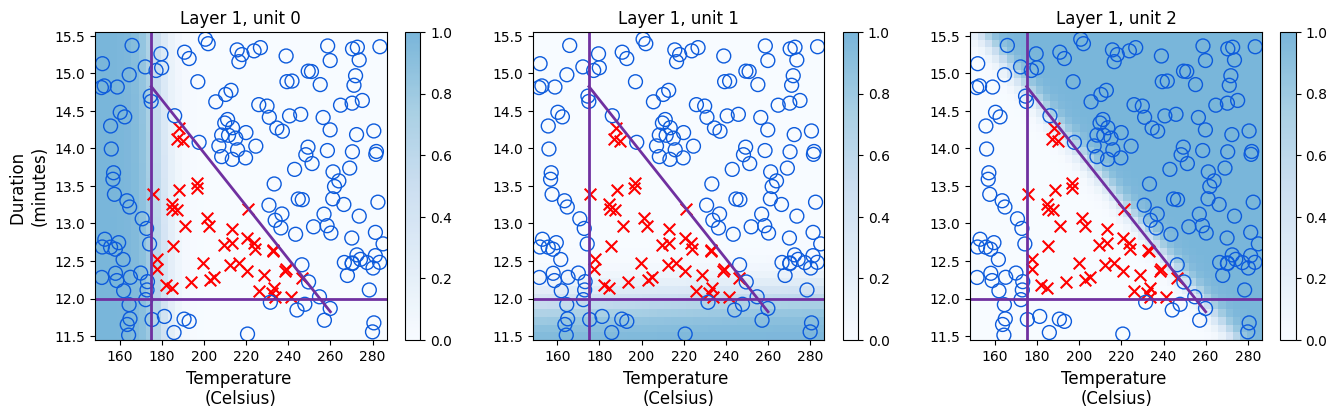

In [23]:
plt_layer(X, Y.reshape(-1,),W1,b1,norm_l)

The shading shows that each unit is responsible for a different "bad roast" region.

- Unit 0 has larger values when teh temperature is too low.
- Unit 1 has larger values when the duration is too short.
- Unit 2 has larger values for bad combinations of time/temp.

The function plot of the final layer is a bit more difficult to visualize. It's input are the ouput of the first layer. We know that the first layer uses sigmoids so their output range is between zero and one. We can create a 3-D plt that calculates the output for all possible combinations of the three inputs. This is shown below. Above, high values correspond to 'dab roast' area's. Below, the maximun output is in area's where the three inputs are in small values corresponding to 'good roast' area's.

In [24]:
def plt_output_init(W,b):
    """plots a single unit function with 3 inputs"""

    steps = 10
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    x_ = np.linspace(0., 1., steps)
    y_ = np.linspace(0., 1., steps)
    z_ = np.linspace(0., 1., steps)
    x, y, z = np.meshgrid(x_, y_, z_,  indexing='ij') #indexing -> 'xy': cartesian; 'ij':matrix
    d = np.zeros((steps, steps, steps))
    cmap = plt.get_cmap('Blues') # Get a colormap instance, defaulting to rc values if name is None
    for i in range(steps):
        for j in range(steps):
            for k in range(steps):
                v = np.array([x[i,j,k], y[i,j,k], z[i,j,k]])
                d[i,j,k] = tf.keras.activations.sigmoid(np.dot(v,W[:,0])+b).numpy() # .numpy() -> Convert tensor (TensorFlow) to an array (NunPy)
    pcm = ax.scatter(x, y, z, c=d, cmap=cmap, alpha=1)
    ax.set_xlabel("unit 0");
    ax.set_ylabel("unit 1");
    ax.set_zlabel("unit 2");
    ax.view_init(30, -120)
    ax.figure.colorbar(pcm, ax=ax)
    ax.set_title(f"Layer 2, output unit")

    plt.show()


/tmp/ipykernel_192814/1427512414.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d[i,j,k] = tf.keras.activations.sigmoid(np.dot(v,W[:,0])+b).numpy() # .numpy() -> Convert tensor (TensorFlow) to an array (NunPy)


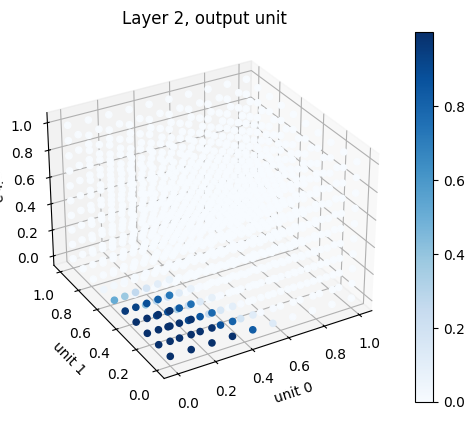

In [25]:
plt_output_init(W2, b2)

In [26]:
def plt_network(X,Y,netf):
    fig, ax = plt.subplots(1,2, figsize=(16,4))
    Y = Y.reshape(-1,)
    plt_prob(ax[0], netf)
    ax[0].scatter(X[Y==1,0],X[Y==1,1], s = 70, marker='x', c='red', label='Good Roast')
    ax[0].scatter(X[Y==0,0],X[Y==0,1], s = 100, marker='o', facecolors='none',
                  edgecolors=dlc["dldarkblue"], linewidth=1, label='Good Roast')
    ax[0].plot(X[:,0], (-3/85) * X[:,0] + 21, color=dlc["dlpurple"], linewidth=1)
    ax[0].axhline(y = 12, color=dlc["dlpurple"], linewidth=1)
    ax[0].axvline(x = 175, color=dlc["dlpurple"], linewidth=1)
    ax[0].set_xlabel("Temperature \n(Celsius)", size=12)
    ax[0].set_ylabel("Duration \n(minutes)", size=12)
    ax[0].legend(loc='upper right')
    ax[0].set_title(f"network probability")

    ax[1].plot(X[:,0], (-3/85) * X[:,0] + 21, color=dlc["dlpurple"], linewidth=1)
    ax[1].axhline(y = 12, color=dlc["dlpurple"], linewidth=1)
    ax[1].axvline(x = 175, color=dlc["dlpurple"], linewidth=1)
    fwb = netf(X)
    yhat = (fwb > 0.5).astype(int)
    ax[1].scatter(X[yhat[:,0]==1,0],X[yhat[:,0]==1,1], s=70, marker='x', c='orange', label="Predicted Good Roast")
    ax[1].scatter(X[yhat[:,0]==0,0],X[yhat[:,0]==0,1], s=100, marker='o', facecolors='none',
                  edgecolors=dlc["dldarkblue"], linewidth=1, label="Predicted Bad Roast")
    ax[1].set_title(f"network decision")
    ax[1].set_xlabel("Temperature \n(Celsius)", size=12)
    ax[1].set_ylabel("Duration \n(minutes)", size=12)
    ax[1].legend(loc='upper right')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


/tmp/ipykernel_192814/1666557548.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z[i,j] = fwb(x)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━

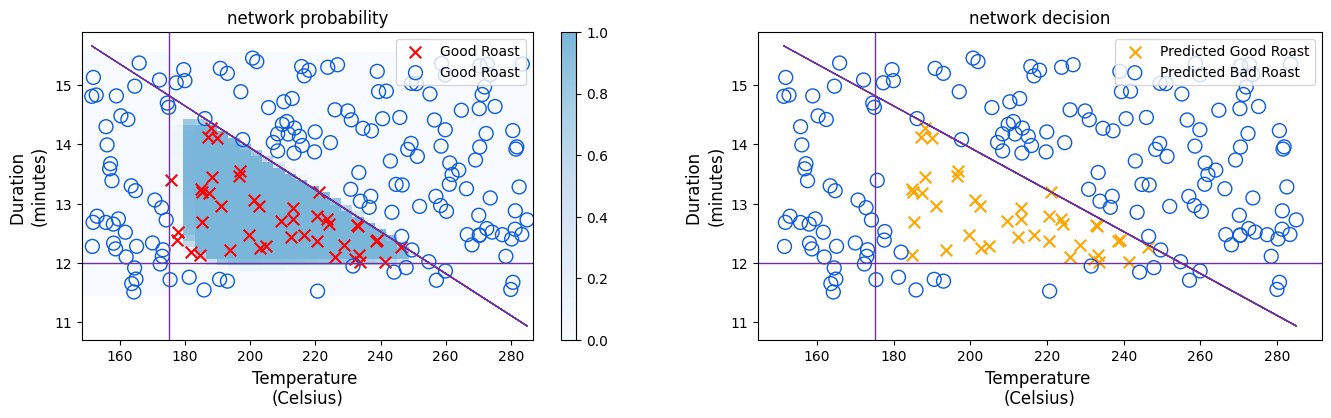

In [27]:
netf = lambda x : model.predict(norm_l(x))
plt_network(X,Y,netf)

The final graph shows the whole network in action.

- The left graph is the raw output of the final layer represented by the blue shading. This is overlaid on the training data represented by the X's and O's.
- The right graph is the output of the network after a decision threshold. The X's and the O's here correspond to decisions made by the network.